## Test function using a statictical test

In [7]:
import math
import statistics

import matplotlib.pyplot as plt
import numpy as np
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.aer import QasmSimulator

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error

$$ Z = \frac{R - R'}{s_r}$$

Where,

R = The number of observed runs

R' = The number of expected runs, given as

$$R' = \frac{2 n_1 n_2}{n_1 + n_2} + 1$$
$s_r$  = Standard Deviation of the number of runs

With n1 and n2 = the number of positive and negative values in the series

If Z<1.96 test passes!

In [8]:
def runsTest(l, l_median): 
    '''
    Returns Z; If Z>1.96 then numbers are not random
    '''
  
    runs, n1, n2 = 0, 0, 0
      
    # Checking for start of new run 
    for i in range(len(l)): 
          
        # no. of runs 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median): 
            runs += 1  
          
        # no. of positive values 
        if(l[i]) >= l_median: 
            n1 += 1   
          
        # no. of negative values 
        else: 
            n2 += 1   
  
    runs_exp = ((2*n1*n2)/(n1+n2))+1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/ (((n1+n2)**2)*(n1+n2-1))) 
  
    z = (runs-runs_exp)/stan_dev 
  
    return z 

In [9]:
def get_noise():
    
    '''
    It returns the the noise model that uses bit flip error noise model.
    When applying a single qubit gate, flip the state of the qubit with probability p_gate1.
    When applying a 2-qubit gate apply single-qubit errors to each qubit.
    When resetting a qubit reset to 1 instead of 0 with probability p_reset.
    When measuring a qubit, flip the state of the qubit with probability p_meas.
    '''
    
    p_reset = 0.03
    p_meas = 0.1
    p_gate1 = 0.05

    # QuantumError objects
    error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate2 = error_gate1.tensor(error_gate1)

    # Add errors to noise model
    noise_bit_flip = NoiseModel()
    noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
    noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
    noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

    return noise_bit_flip

def random_number():
    '''
    Returns random numbers between 0 to 15
    '''

    circ = QuantumCircuit(4)
    simulator = QasmSimulator()

    #NQRNS Circuit
    for i in range(200):
        circ.u3(0,0,0,0)
        circ.u3(0,0,0,1)
        circ.u3(0,0,0,2)
        circ.u3(0,0,0,3)
        circ.cx(0,1)
        circ.cx(1,2)
        circ.cx(0,2)
        circ.cx(0,3)
        circ.cx(1,3)
        circ.cx(2,3)
        circ.barrier()

    circ.measure_all()

    noise_bit_flip = get_noise()
    #get output
    job = execute(circ, simulator,
              basis_gates=noise_bit_flip.basis_gates,
              noise_model=noise_bit_flip, shots= 1)
    result_bit_flip = job.result()
    counts_bit_flip = result_bit_flip.get_counts(0)


    num=list(counts_bit_flip.keys())[0]
    num = int(num, 2)
   

    return num

In [13]:
l= []

for i in range(100): 
    l.append(random_number()) 
      
l_median= statistics.median(l) 
  
Z = abs(runsTest(l, l_median)) 
  
print('Z-statistic= ', Z)

Z-statistic=  0.20948264539909806


Voila! It is well under 1.96 hence the test is passed!

## Testing with FFT

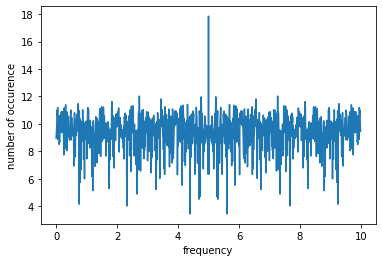

In [12]:
dt = .1 #some time

n = 1000 #n-number of datapoints

for i in range(1000): 
    l.append(random_number()) 
    
fhat=np.fft.fft(l,n) #f-data ,n-number of datapoints per set

freq=(1/(dt*n))*np.arange(n)

PSD2=np.log(np.abs(np.fft.fftshift(fhat))**2)

plt.plot(freq.real,PSD2.real)
plt.xlabel('frequency')
plt.ylabel('number of occurence')
plt.show()